# Project

**BELBACHIR Yassine - MARTIN Maxence**

## Goals

- Implementation of a well-commented [Recommender system](https://en.wikipedia.org/wiki/Recommender_system) in Python.
  - Automate image data collection and annotation.  
  - Analyze data to identify trends.
  - Visualize analysis results effectively.  
  - Build and validate a recommendation system.
  - Ensure thorough testing of all components.  
- Present findings in a detailed report.  


The goal of this project is to recommend images based on the preferences
of the user. You have three practical sessions to build this system. You
must ensure that all the tasks related to data acquisition, annotation,
analysis, and visualization are automated.

The main tasks of the project are given below:

1.  Data Collection
2.  Labeling and Annotation
3.  Data Analyses
4.  Data Visualization
5.  Recommendation System


![Architecture](../../images/Project-Architecture.png "Architecture")

## Imports

In [56]:
import os
import sys
import json
import random
import requests
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from PIL import Image, ExifTags, ImageTk
from tkinter import messagebox, simpledialog
import tkinter as tk
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


## Data Collection


In [57]:
endpoint_url = "https://query.wikidata.org/sparql"

# Get Animals
query = """SELECT DISTINCT ?animal ?image ?taxon WHERE {
  {
    # Mammals and birds (~50%)
    SELECT DISTINCT ?animal ?image ?taxon WHERE {
      ?animal wdt:P171 ?taxon;    # Get its parent taxon
              wdt:P18 ?image.     # Ensure it has an image
      FILTER NOT EXISTS { ?animal wdt:P31 wd:Q23038290 }
      VALUES ?taxon { 
        wd:Q7377    # Mammals
        wd:Q5113    # Birds
        wd:Q25306   # Carnivores (Mammals)
        wd:Q10850   # Rodents (Mammals)
        wd:Q7380    # Primates (Mammals)
        wd:Q25336   # Marsupials (Mammals)
        wd:Q10908   # Amphibians
        # More specific mammal families and orders
        wd:Q146     # Felines (Felidae)
        wd:Q25265
        wd:Q25324   # Canines (Canidae)
        wd:Q25437  # Mustelids (Otters, Weasels, Badgers)
        wd:Q25497    # Bovids (Cows, Sheep, Antelopes)
        wd:Q165115   # Equines (Horses, Zebras)
        wd:Q23390  
        wd:Q160      # Cetaceans (Whales, Dolphins)
        wd:Q28425   # Bats (Chiroptera)
      }
    } LIMIT 300
  }
  UNION
  {
    # Reptiles, Fish, and Crustaceans (~30%)
    SELECT DISTINCT ?animal ?image ?taxon WHERE {
      ?animal wdt:P171 ?taxon;
              wdt:P18 ?image.
      VALUES ?taxon { 
        wd:Q10811   # Reptiles
        wd:Q152     # Fish
        wd:Q25364   # Crustaceans
        wd:Q46360   # Turtles (Testudines)
        wd:Q25363   # Crocodilians
        wd:Q122422  # Squamates (Lizards & Snakes)
        wd:Q25371   # Cartilaginous Fish (Sharks & Rays)
      }
    } LIMIT 200
  }
  UNION
  {
    # Invertebrates (~20%)
    SELECT DISTINCT ?animal ?image ?taxon WHERE {
      ?animal wdt:P171 ?taxon;
              wdt:P18 ?image.
      VALUES ?taxon { 
        wd:Q25326   # Mollusks
        wd:Q1358    # Arachnids
        wd:Q1390    # Insects
        wd:Q25441   # Cnidarians
        wd:Q44631   # Echinoderms
        wd:Q128257  # Cephalopods (Squid, Octopus)
        wd:Q22671   # Coleoptera (Beetles)
        wd:Q22651   # Hymenoptera (Bees, Wasps, Ants)
      }
    } LIMIT 150
  }
} LIMIT 15
"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    array.append(
        (
            result["taxon"]["value"],
            result["image"]["value"],
        )
    )

array

[('http://www.wikidata.org/entity/Q128257',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Estonioceras%20decheni%2001.jpg'),
 ('http://www.wikidata.org/entity/Q128257',
  'http://commons.wikimedia.org/wiki/Special:FilePath/NautilusCutawayLogarithmicSpiral.jpg'),
 ('http://www.wikidata.org/entity/Q128257',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Georgia%20Aquarium%20-%20Cuttlefish%20Jan%202006.jpg'),
 ('http://www.wikidata.org/entity/Q128257',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Loligo%20vulgaris.jpg'),
 ('http://www.wikidata.org/entity/Q128257',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Orthoceras%20%28Maroc%29.JPG'),
 ('http://www.wikidata.org/entity/Q23390',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Dicrocerus%20furcatus.JPG'),
 ('http://www.wikidata.org/entity/Q10908',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Dermophis%20mexicanus.jpg'),
 ('http://www.wikidata.org/entity/Q25437',
  'http://commons.wikimedia

## Download, Labeling and Annotation

In [ ]:
# Folder to store images
IMAGE_FOLDER = "images"
ANNOTATIONS_FILE = "annotations.json"

# Ensure the image folder exists
os.makedirs(IMAGE_FOLDER, exist_ok=True)

# Load existing annotations if available
if os.path.exists(ANNOTATIONS_FILE):
    with open(ANNOTATIONS_FILE, "r") as f:
        try:
            existing_annotations = json.load(f)
        except json.JSONDecodeError:
            existing_annotations = []
else:
    existing_annotations = []

# Convert existing annotations into a dictionary for quick lookup
processed_images = {entry["image"]: entry for entry in existing_annotations}


image_data = [
    {"taxon": item[0], "image_url": item[1]}
    for item in array
]

def download_images():
    for idx, data in enumerate(image_data):
        image_url = data["image_url"]
        image_name = f"image_{idx}.jpg"
        image_path = os.path.join(IMAGE_FOLDER, image_name)

        if os.path.exists(image_path):
            print(f"Skipping {image_name} (already exists)")
            continue

        print(f"Downloading {image_name}...")
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(image_url, stream=True, headers=headers)

        if response.status_code == 200:
            with open(image_path, "wb") as file:
                file.write(response.content)
            print(f" Downloaded: {image_name}")
        else:
            print(f" Failed to download: {image_url}")

            
# Function to extract EXIF metadata
def get_exif_metadata(image_path):
    metadata = {}
    try:
        image = Image.open(image_path)
        exif_data = image._getexif()

        if exif_data:
            for tag, value in exif_data.items():
                tag_name = ExifTags.TAGS.get(tag, tag)

                # Convert values to JSON-compatible format
                if isinstance(value, tuple):
                    value = tuple(float(v) if isinstance(v, (int, float)) else str(v) for v in value)
                elif isinstance(value, int) or isinstance(value, float):
                    value = float(value)
                elif isinstance(value, bytes):
                    try:
                        value = value.decode('utf-8')  
                    except UnicodeDecodeError:
                        value = str(value)  
                elif isinstance(value, str):
                    pass  
                else:
                    value = str(value) 

                metadata[tag_name] = value

        # Add additional image properties
        metadata["format"] = image.format
        metadata["size"] = image.size
        metadata["mode"] = image.mode

    except Exception as e:
        print(f" Error extracting EXIF from {image_path}: {e}")

    return metadata

def get_dominant_colors(image_path, k=3):
    try:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.reshape((-1, 3))

        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(image)

        colors = kmeans.cluster_centers_.astype(int)
        color_counts = Counter(kmeans.labels_)
        sorted_colors = [colors[i].tolist() for i in color_counts.keys()]

        return sorted_colors
    except Exception as e:
        print(f"Error extracting colors from {image_path}: {e}")
        return []

def process_images():
    annotations = existing_annotations.copy()

    for idx, data in enumerate(image_data):
        image_name = f"image_{idx}.jpg"
        image_path = os.path.join(IMAGE_FOLDER, image_name)

        if image_name in processed_images:
            print(f"Skipping {image_name}, already processed.")
            continue

        if not os.path.exists(image_path):
            print(f"Skipping {image_name}, image file not found")
            continue

        print(f"Processing {image_name}...")
        metadata = get_exif_metadata(image_path)
        colors = get_dominant_colors(image_path)
        tags = [f"color_{color}" for color in colors]

        annotation_entry = {
            "taxon": data["taxon"],
            "image": image_name,
            "metadata": metadata,
            "dominant_colors": colors,
            "tags": tags
        }
        annotations.append(annotation_entry)
        processed_images[image_name] = annotation_entry

    with open(ANNOTATIONS_FILE, "w") as f:
        json.dump(annotations, f, indent=4)
    print(f"Annotations saved to {ANNOTATIONS_FILE}")


download_images()
process_images()

Skipping image_0.jpg (already exists)
Skipping image_1.jpg (already exists)
Skipping image_2.jpg (already exists)
Skipping image_3.jpg (already exists)
Skipping image_4.jpg (already exists)
Skipping image_5.jpg (already exists)
Skipping image_6.jpg (already exists)
Skipping image_7.jpg (already exists)
Skipping image_8.jpg (already exists)
Skipping image_9.jpg (already exists)
Skipping image_10.jpg (already exists)
Skipping image_11.jpg (already exists)
Skipping image_12.jpg (already exists)
Skipping image_13.jpg (already exists)
Skipping image_14.jpg (already exists)
Skipping image_0.jpg, already processed.
Skipping image_1.jpg, already processed.
Skipping image_2.jpg, already processed.
Skipping image_3.jpg, already processed.
Skipping image_4.jpg, already processed.
Skipping image_5.jpg, already processed.
Skipping image_6.jpg, already processed.
Skipping image_7.jpg, already processed.
Skipping image_8.jpg, already processed.
Skipping image_9.jpg, already processed.
Skipping image_

## User Interface

In [ ]:
# Initialize GUI at the beginning
root = tk.Tk()
root.title("Image Selection & Tagging")

# Folder where images are stored
IMAGE_FOLDER = "images"
USER_DATA_FILE = "user_preferences.json"

# Load image file names and randomly select 10
image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.endswith(('.jpg', '.png', '.jpeg'))]
random.shuffle(image_files)
image_files = image_files[:10]

# Data storage
selected_images = []  
image_tags = {}  
favorite_images = [] 
image_refs = {}  
# Function to handle image selection
def select_image(filename):
    if filename in selected_images:
        selected_images.remove(filename)
        buttons[filename]["bg"] = "SystemButtonFace"
    else:
        if len(selected_images) < 5: 
            selected_images.append(filename)
            buttons[filename]["bg"] = "lightblue"
        else:
            messagebox.showinfo("Selection Limit", "You can select up to 5 images.")

# Function to add tags to selected images
def add_tags():
    global image_tags
    for img in selected_images:
        tag = simpledialog.askstring("Tag Image", f"Enter tags for {img} (comma-separated):")
        if tag:
            image_tags[img] = tag.split(",")

# Function to mark selected images as favorite
def select_favorite():
    global favorite_images
    if not selected_images:
        messagebox.showinfo("No Selection", "Please select at least one image first.")
        return
    favorite_images.extend(selected_images)
    messagebox.showinfo("Favorite Selected", "Selected images have been marked as favorites.")




# Create frame for images
frame = tk.Frame(root)
frame.pack()

buttons = {}

# Load and display randomly selected images while keeping aspect ratio
for img_file in image_files:
    img_path = os.path.join(IMAGE_FOLDER, img_file)
    
    try:
        # Open image and maintain aspect ratio
        img = Image.open(img_path)
        img.thumbnail((100, 100)) 
        img = ImageTk.PhotoImage(img)

        # Store image reference to prevent garbage collection
        image_refs[img_file] = img  

        # Create button for image selection
        btn = tk.Button(frame, image=img, command=lambda f=img_file: select_image(f))
        btn.image = img 
        btn.pack(side=tk.LEFT, padx=5, pady=5)
        buttons[img_file] = btn
    except Exception as e:
        print(f"Error loading image {img_file}: {e}")

# Buttons for tagging, favorite selection, and saving
btn_tags = tk.Button(root, text="Add Tags", command=add_tags)
btn_tags.pack()

btn_fav = tk.Button(root, text="Mark Selected as Favorite", command=select_favorite)
btn_fav.pack()



# Run the GUI loop
root.mainloop()


## Data Analyses and Visualization

The block bellow doesn't work properly

In [ ]:
# Load user preferences and annotations
USER_DATA_FILE = "user_preferences.json"
ANNOTATIONS_FILE = "annotations.json"

# Function to safely load JSON files (handles empty files)
def load_json_safely(filepath):
    if os.path.exists(filepath) and os.path.getsize(filepath) > 0: 
        with open(filepath, "r") as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                print(f"Warning: {filepath} is not a valid JSON file. Using empty dictionary.")
                return {}
    return {} 
# Load JSON data safely
user_data = load_json_safely(USER_DATA_FILE)
annotations = load_json_safely(ANNOTATIONS_FILE)

# Ensure user_data is a dictionary
if not isinstance(user_data, dict):
    print("Warning: user_data is not a dictionary. Resetting to an empty dictionary.")
    user_data = {}

# Extract relevant data safely
selected_images = user_data.get("selected_images", [])
favorite_images = user_data.get("favorite_images", [])
image_tags = user_data.get("image_tags", {})

# Frequency analysis of selected images
selected_counts = Counter(selected_images)
favorite_counts = Counter(favorite_images)

# Most common selected and favorite images
most_selected = selected_counts.most_common(5)
most_favorited = favorite_counts.most_common(5)

print("Top 5 Most Selected Images:", most_selected)
print("Top 5 Most Favorited Images:", most_favorited)

# Ensure annotations is a list
if not isinstance(annotations, list):
    print("Error: Annotations data is not a list. Check the JSON format.")
    annotations = []  

# Extract image sizes, formats, orientations, and user preferences
image_sizes = []
image_formats = []
image_orientations = {"Portrait": 0, "Landscape": 0, "Square": 0}
favorite_colors = Counter()
favorite_sizes = Counter()
favorite_tags = Counter()

for entry in annotations: 
    if isinstance(entry, dict) and "image" in entry:  
        img_file = entry["image"]
        img_path = os.path.join("images", img_file)
        
        try:
            img = Image.open(img_path)
            width, height = img.size
            image_sizes.append((width, height))
            image_formats.append(img.format)

            # Determine orientation
            if width > height:
                image_orientations["Landscape"] += 1
            elif height > width:
                image_orientations["Portrait"] += 1
            else:
                image_orientations["Square"] += 1
            
            # Extract additional user preference data
            if img_file in favorite_images:
                favorite_sizes[(width, height)] += 1
                
                if "dominant_colors" in entry:
                    for color in entry["dominant_colors"]:
                        favorite_colors[tuple(color)] += 1
                
                if "tags" in entry:
                    favorite_tags.update(entry["tags"])
        
        except Exception as e:
            print(f"Skipping {img_file}: {e}")

# Convert image sizes to width & height lists
image_widths = [size[0] for size in image_sizes]
image_heights = [size[1] for size in image_sizes]

# Summary statistics for image sizes
if image_widths and image_heights:
    print(f"Average Image Size: {int(np.mean(image_widths))} x {int(np.mean(image_heights))} pixels")
    print(f"Median Image Size: {int(np.median(image_widths))} x {int(np.median(image_heights))} pixels")

# Visualizing User Preferences
plt.figure(figsize=(10, 5))
if favorite_colors:
    colors, counts = zip(*favorite_colors.most_common(10))
    plt.bar(range(len(colors)), counts, color=[(r/255, g/255, b/255) for r, g, b in colors])
    plt.xticks(range(len(colors)), [str(c) for c in colors], rotation=45)
    plt.xlabel("Color (RGB)")
    plt.ylabel("Count")
    plt.title("Top 10 Favorite Colors")
    plt.show()

if favorite_sizes:
    sizes, counts = zip(*favorite_sizes.most_common(10))
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(sizes)), counts, color='purple')
    plt.xticks(range(len(sizes)), [f"{w}x{h}" for w, h in sizes], rotation=45)
    plt.xlabel("Image Size (WxH)")
    plt.ylabel("Count")
    plt.title("Top 10 Favorite Image Sizes")
    plt.show()

if favorite_tags:
    tags, counts = zip(*favorite_tags.most_common(10))
    plt.figure(figsize=(10, 5))
    plt.bar(tags, counts, color='green', alpha=0.7)
    plt.xlabel("Tags")
    plt.ylabel("Count")
    plt.title("Top 10 Favorite Tags")
    plt.xticks(rotation=45)
    plt.show()

print("User preference analysis completed. Check visualizations.")


Top 5 Most Selected Images: []
Top 5 Most Favorited Images: []
Average Image Size: 2370 x 1813 pixels
Median Image Size: 2240 x 1693 pixels
User preference analysis completed. Check visualizations.


<Figure size 1000x500 with 0 Axes>

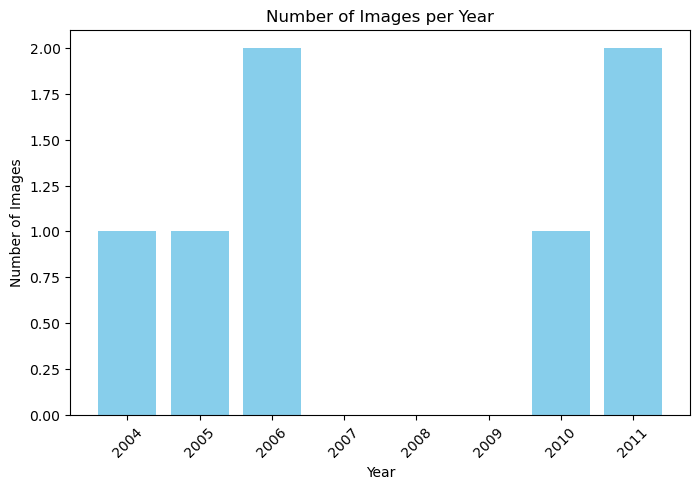

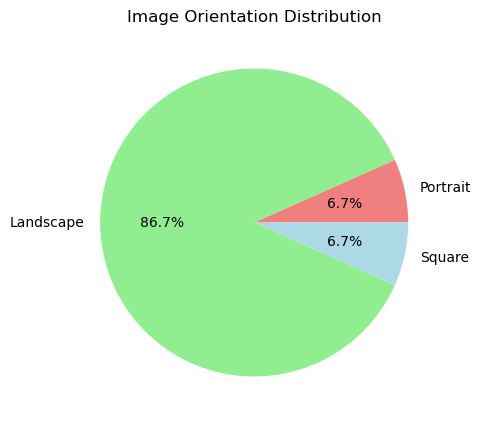

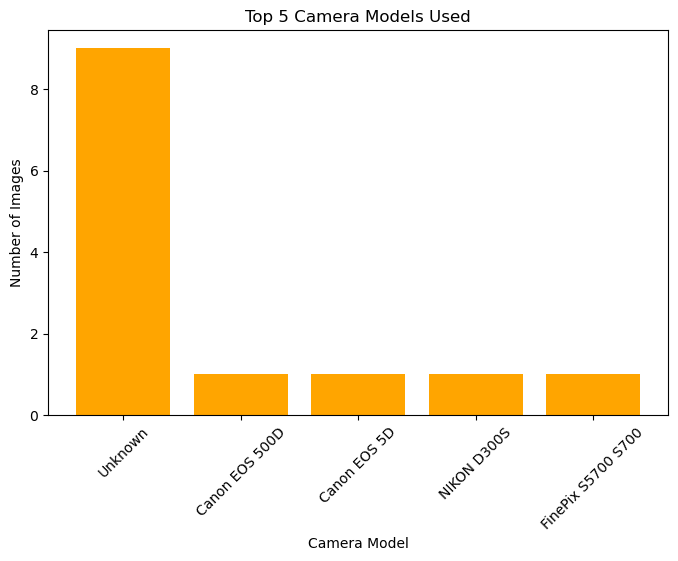

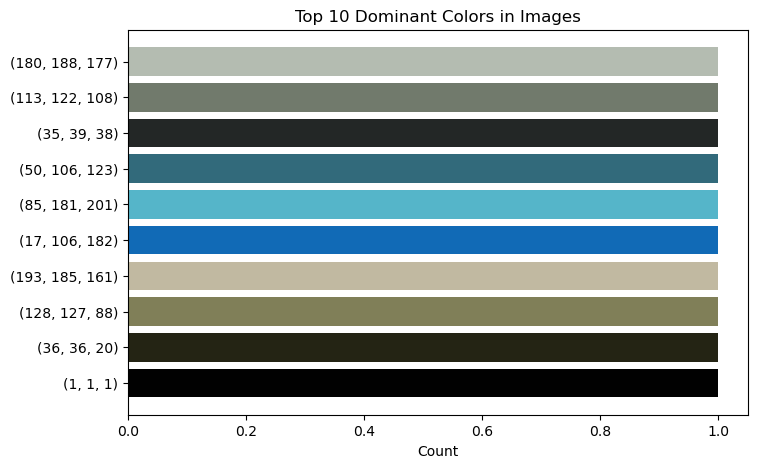

In [ ]:
def visualize_image_data(annotations_path):
    # Load annotations from JSON file
    with open(annotations_path, "r") as f:
        annotations = json.load(f)

    # Extract relevant data
    image_years = []
    image_sizes = []
    image_orientations = []
    camera_models = []
    dominant_colors = []

    for image in annotations:
        # Extract Year from metadata if available
        date_str = image["metadata"].get("DateTimeOriginal") or image["metadata"].get("DateTime")
        if date_str:
            try:
                year = datetime.strptime(date_str, "%Y:%m:%d %H:%M:%S").year
                image_years.append(year)
            except ValueError:
                pass

        # Extract Image Size and Orientation
        width, height = image["metadata"].get("size", (0, 0))
        image_sizes.append(width * height)
        if width > height:
            image_orientations.append("Landscape")
        elif width < height:
            image_orientations.append("Portrait")
        else:
            image_orientations.append("Square")

        # Extract Camera Model
        camera_model = image["metadata"].get("Model", "Unknown")
        camera_models.append(camera_model)

        # Extract Dominant Colors
        dominant_colors.extend(image.get("dominant_colors", []))

    # Convert Lists to Pandas DataFrames for visualization
    df_years = pd.DataFrame(Counter(image_years).items(), columns=["Year", "Count"])
    df_sizes = pd.DataFrame(Counter(image_sizes).items(), columns=["Size (px²)", "Count"])
    df_orientations = pd.DataFrame(Counter(image_orientations).items(), columns=["Orientation", "Count"])
    df_cameras = pd.DataFrame(Counter(camera_models).items(), columns=["Camera Model", "Count"])

    # Plot Data Visualizations
    # Number of images per year
    plt.figure(figsize=(8, 5))
    plt.bar(df_years["Year"], df_years["Count"], color="skyblue")
    plt.xlabel("Year")
    plt.ylabel("Number of Images")
    plt.title("Number of Images per Year")
    plt.xticks(rotation=45)
    plt.show()

    # Image orientation distribution
    plt.figure(figsize=(6, 5))
    plt.pie(df_orientations["Count"], labels=df_orientations["Orientation"], autopct='%1.1f%%', colors=["lightcoral", "lightgreen", "lightblue"])
    plt.title("Image Orientation Distribution")
    plt.show()

    # Camera model distribution (Top 5 Models)
    top_cameras = df_cameras.sort_values(by="Count", ascending=False).head(5)
    plt.figure(figsize=(8, 5))
    plt.bar(top_cameras["Camera Model"], top_cameras["Count"], color="orange")
    plt.xlabel("Camera Model")
    plt.ylabel("Number of Images")
    plt.title("Top 5 Camera Models Used")
    plt.xticks(rotation=45)
    plt.show()

    # Color characteristics visualization
    dominant_colors_flat = [tuple(color) for color in dominant_colors] 
    df_colors = pd.DataFrame(Counter(dominant_colors_flat).items(), columns=["Color (RGB)", "Count"])
    df_colors = df_colors.sort_values(by="Count", ascending=False).head(10) 

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(df_colors)), df_colors["Count"], color=[(r/255, g/255, b/255) for r, g, b in df_colors["Color (RGB)"]])
    plt.yticks(range(len(df_colors)), df_colors["Color (RGB)"])
    plt.xlabel("Count")
    plt.title("Top 10 Dominant Colors in Images")
    plt.show()

# Example usage
visualize_image_data("annotations.json")


## Recommendation System

The block bellow doesn't work properly

In [ ]:
# Load user preferences and annotations
USER_DATA_FILE = "user_preferences.json"
ANNOTATIONS_FILE = "annotations.json"
IMAGE_FOLDER = "images"

# Function to safely load JSON files (handles empty files)
def load_json_safely(filepath):
    if os.path.exists(filepath) and os.path.getsize(filepath) > 0:
        with open(filepath, "r") as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                print(f"Warning: {filepath} is not a valid JSON file. Using empty list.")
                return []
    return []

# Load JSON data safely
user_data = load_json_safely(USER_DATA_FILE)
annotations = load_json_safely(ANNOTATIONS_FILE)

# Extract relevant data
selected_images = user_data.get("selected_images", [])
favorite_images = user_data.get("favorite_images", [])
image_tags = user_data.get("image_tags", {})

# Extract user preferences
favorite_colors = Counter()
favorite_tags = Counter()
favorite_sizes = Counter()
favorite_orientations = Counter()

feature_data = []
labels = []

for entry in annotations:
    if isinstance(entry, dict) and "image" in entry:
        img_file = entry["image"]
        img_metadata = entry.get("metadata", {})

        color = tuple(entry.get("dominant_colors", [(0, 0, 0)])[0])  
        size = img_metadata.get("size", (0, 0))
        orientation = "Landscape" if size[0] > size[1] else "Portrait" if size[0] < size[1] else "Square"
        tags = entry.get("tags", [])
        
        favorite_colors[color] += 1
        favorite_sizes[size] += 1
        favorite_orientations[orientation] += 1
        favorite_tags.update(tags)
        
        feature_data.append([color, tags[0] if tags else "Unknown", size, orientation])
        labels.append("Favorite" if img_file in favorite_images else "NotFavorite")

# Encode categorical features
label_encoders = [LabelEncoder() for _ in range(len(feature_data[0]))]
encoded_data = []
for i, column in enumerate(zip(*feature_data)):
    encoded_data.append(label_encoders[i].fit_transform(column))

X = list(zip(*encoded_data))
y = labels

# Split data and train SVM classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = svm.SVC()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

# Recommend images to the user
recommendations = []
for entry in annotations:
    if isinstance(entry, dict) and "image" in entry:
        img_file = entry["image"]
        img_metadata = entry.get("metadata", {})
        
        color = tuple(entry.get("dominant_colors", [(0, 0, 0)])[0])
        size = img_metadata.get("size", (0, 0))
        orientation = "Landscape" if size[0] > size[1] else "Portrait" if size[0] < size[1] else "Square"
        tags = entry.get("tags", [])
        
        sample_item = [color, tags[0] if tags else "Unknown", size, orientation]
        encoded_item = [label_encoders[i].transform([val])[0] for i, val in enumerate(sample_item)]
        prediction = classifier.predict([encoded_item])[0]
        
        if prediction == "Favorite":
            recommendations.append(img_file)

# Display recommended images
print("Recommended Images:")
for img_file in recommendations[:5]: 
    img_path = os.path.join(IMAGE_FOLDER, img_file)
    try:
        img = Image.open(img_path)
        img.show()
    except Exception as e:
        print(f"Could not display {img_file}: {e}")

print("Recommendation process completed.")


AttributeError: 'list' object has no attribute 'get'